<a href="https://colab.research.google.com/github/ribeirowski/ES413_Sinais/blob/main/projeto_sinais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
# Clone repository with the dataset folder
!git clone https://github.com/ribeirowski/ES413_Sinais.git

# Create a folder to save the preprocessed audios
!mkdir NewDataset

fatal: destination path 'ES413_Sinais' already exists and is not an empty directory.
mkdir: cannot create directory ‘NewDataset’: File exists


In [106]:
import numpy as np
import random as rd
import librosa as lb
import soundfile as sf
import seaborn as sns
import pandas as pd
from sklearn.svm import SVC
import scipy.signal as signal
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [107]:
# Dictionary with the name of the animals and the number of their files
animals = {"cat": 240, "cow": 114, "dog": 240, "frog": 75, "lion": 45, "sheep": 80}

# Set the default audio length
length = 5

def preprocessing(dic):
  for animal, files in dic.items():
    for i in range(1, files + 1):
      audio_file = f"ES413_Sinais/dataset/{animal}/{animal}_{i}.wav"

      # Load audio files
      audio, sr = lb.load(audio_file)

      # Get the audio duration
      audio_length = lb.get_duration(y=audio, sr=sr)

      # Get the number of audio samples
      audio_samples = int(length * sr)

      # Truncate audio if it's longer or equal than length (5s)
      if audio_length >= length:
          new_audio = audio[:audio_samples]
      # Extends audio if it's smaller than length (5s)
      elif audio_length < length:
          miss_sample = audio_samples - len(audio)
          new_audio = np.concatenate((audio, np.zeros(miss_sample)))

      # Highpass filter
      freq = 50
      b, a = signal.butter(4, freq / (sr / 2), 'high')
      audio_hp = signal.filtfilt(b, a, new_audio)

      # Lowpass filter
      freq = 8000
      b, a = signal.butter(4, freq / (sr / 2), 'low')
      audio_lp = signal.filtfilt(b, a, audio_hp)

      # Audio normalization
      normalized_audio = lb.util.normalize(audio_lp)

      # Save the preprocessed file
      new_audio_file = f"NewDataset/new_{animal}_{i}.wav"
      sf.write(new_audio_file, normalized_audio, sr)

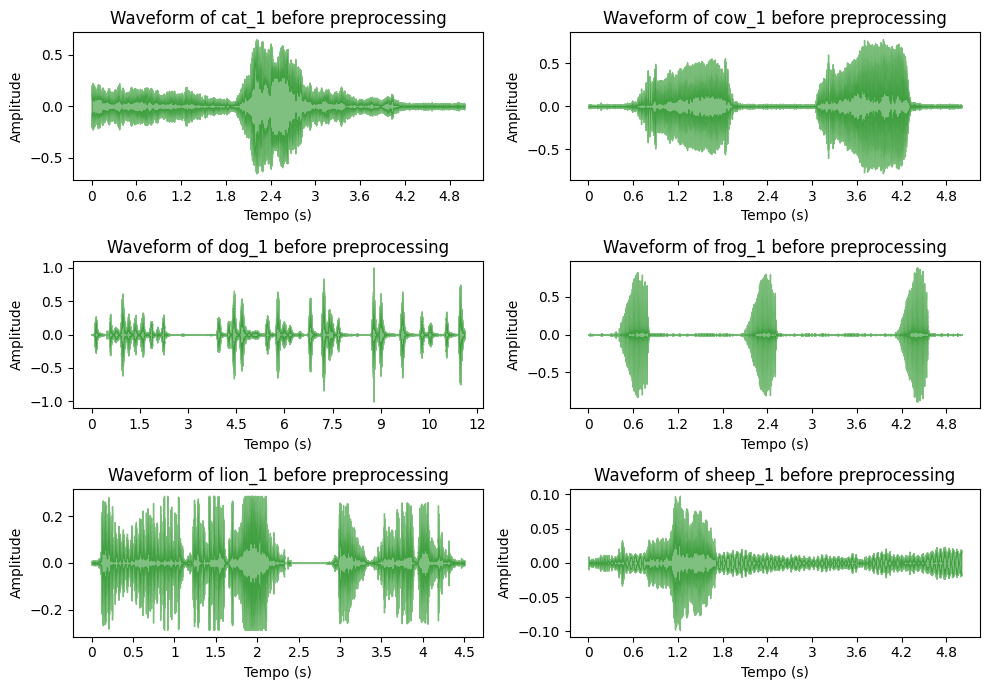

In [108]:
# Criar uma figura para o subplot
plt.figure(figsize=(10, 7))

# Iterar sobre cada animal no dicionário
for idx, (animal, qtd) in enumerate(animals.items(), start=1):
    # Carregar o arquivo de áudio
    audio_file = f"ES413_Sinais/dataset/{animal}/{animal}_1.wav"
    audio, sr = lb.load(audio_file)

    # Adicionar um subplot
    plt.subplot(3, 2, idx)

    # Exibir o waveform
    lb.display.waveshow(audio, color='green',alpha=0.5)
    plt.title(f'Waveform of {animal}_1 before preprocessing')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')

# Ajustar layout
plt.tight_layout()
plt.show()

In [109]:
# Audio preprocessing
preprocessing(animals)

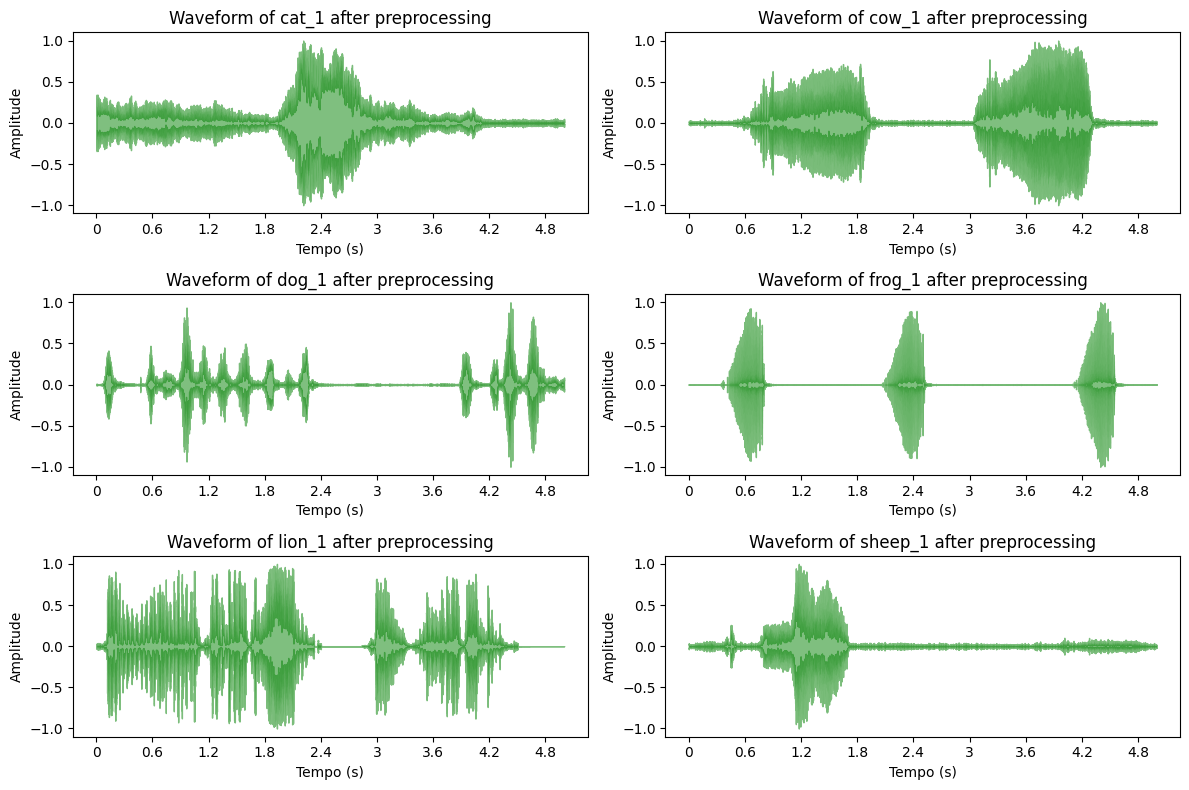

In [110]:
# Criar uma figura para o subplot
plt.figure(figsize=(12, 8))

# Iterar sobre cada animal no dicionário
for idx, (animal, qtd) in enumerate(animals.items(), start=1):
    # Carregar o arquivo de áudio
    audio_file = f"NewDataset/new_{animal}_1.wav"
    audio, sr = lb.load(audio_file)

    # Adicionar um subplot
    plt.subplot(3, 2, idx)

    # Exibir o waveform
    lb.display.waveshow(audio, color='green',alpha=0.5)
    plt.title(f'Waveform of {animal}_1 after preprocessing')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')

# Ajustar layout
plt.tight_layout()
plt.show()

In [111]:
def featureExtraction(dic_audio):
  sc = []
  sb = []
  mfcc = []
  labels = []
  features = []
  audio_fft_freq = []

  for animal, qtd in dic_audio.items():
      for i in range(1, qtd + 1):
        audio_file = f"NewDataset/new_{animal}_{i}.wav"

        # Load the preprocessed audio files
        audio, sr = lb.load(audio_file)

        # Fourier Transform with mean and variance
        audio_fft = np.abs(np.fft.fft(audio))
        audio_fft_avg = np.mean(audio_fft)
        audio_fft_var = np.var(audio_fft)

        # Fourier Transform frequencies
        fft_freq = np.fft.fftfreq(len(audio), 1 / sr)
        audio_fft_freq.append(fft_freq)

        # MFCC with mean and variance
        audio_mfcc = lb.feature.mfcc(y=audio, sr=sr)
        audio_mfcc_avg = np.mean(audio_mfcc)
        audio_mfcc_var = np.var(audio_mfcc)

        mfcc.append([audio_mfcc])

        # Spectral Centroid with mean and variance
        audio_sc = lb.feature.spectral_centroid(y=audio, sr=sr)
        audio_sc_avg = np.mean(audio_sc)
        audio_sc_var = np.var(audio_sc)

        sc.append([audio_sc])

        # Spectral Bandwidth with mean and variance
        audio_sb = lb.feature.spectral_bandwidth(y=audio, sr=sr)
        audio_sb_avg = np.mean(audio_sb)
        audio_sb_var = np.var(audio_sb)

        sb.append([audio_sb])

        # Append the extracted features to the list
        features.append([*audio_fft,
                         audio_fft_avg,
                         audio_fft_var,
                         *audio_mfcc.flatten(),
                         audio_mfcc_avg,
                         audio_mfcc_var,
                         *audio_sc.flatten(),
                         audio_sc_avg,
                         audio_sc_var,
                         *audio_sb.flatten(),
                         audio_sb_avg,
                         audio_sb_var])

      # Append the label to the list
      labels += [animal] * qtd

  return features, labels, audio_fft_freq, mfcc, sc, sb

In [112]:
# Extracting features
features, labels, audio_fft_freq, audio_mfcc, audio_sc, audio_sb = featureExtraction(animals)

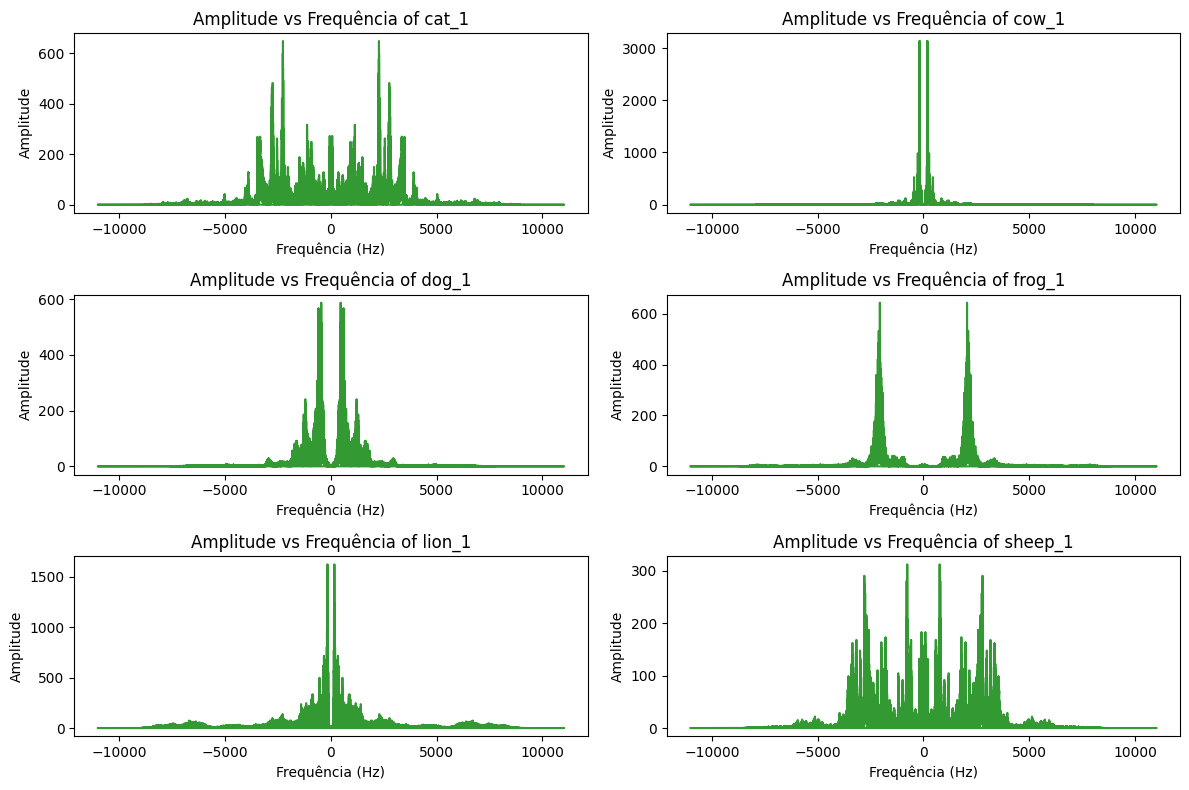

In [113]:
# Criar uma figura para o subplot
plt.figure(figsize=(12, 8))

# Iterar sobre cada animal no dicionário
for idx, (animal, qtd) in enumerate(animals.items(), start=1):
    # Extrair os dados do primeiro animal de cada espécie
    audio_idx = labels.index(animal)

    # Obter os valores de amplitude e frequência do FFT
    audio = features[audio_idx]
    fft_freq = audio_fft_freq[audio_idx]

    # Adicionar um subplot
    plt.subplot(3, 2, idx)

    # Plotar o gráfico de amplitude em função da frequência
    plt.plot(fft_freq, audio[:len(fft_freq)], color='g', alpha=0.8)
    plt.title(f'Amplitude vs Frequência of {animal}_1')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Amplitude')

# Ajustar layout
plt.tight_layout()
plt.show()

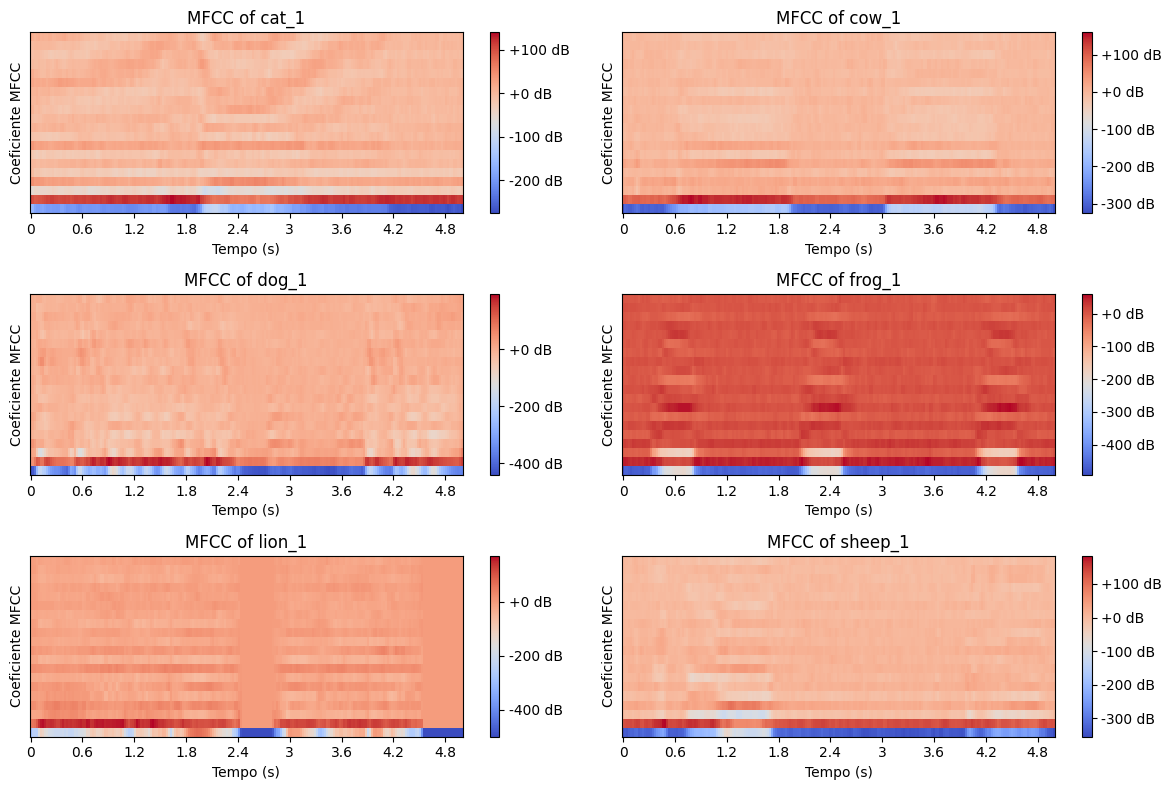

In [114]:
# Criar uma figura para o subplot
plt.figure(figsize=(12, 8))

# Contador de subplots
subplot_counter = 1

# Iterar sobre cada animal no dicionário
for idx, (animal, qtd) in enumerate(animals.items(), start=1):
    # Se for o primeiro animal do tipo
    if idx == 1 or animal != prev_animal:
        # Encontrar o índice do primeiro exemplo de cada animal
        audio_idx = labels.index(animal)

        # Obter o áudio e a taxa de amostragem
        audio = features[audio_idx]
        sr = lb.get_samplerate(f"NewDataset/new_{animal}_1.wav")

        # Coeficientes MFCC
        mfccs = np.array(audio_mfcc[audio_idx][0])

        # Adicionar um subplot para MFCC
        plt.subplot(3, 2, subplot_counter)
        lb.display.specshow(mfccs, x_axis='time', sr=sr)
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'MFCC of {animal}_1')
        plt.xlabel('Tempo (s)')
        plt.ylabel('Coeficiente MFCC')

        subplot_counter += 1

    prev_animal = animal

# Ajustar layout
plt.tight_layout()
plt.show()

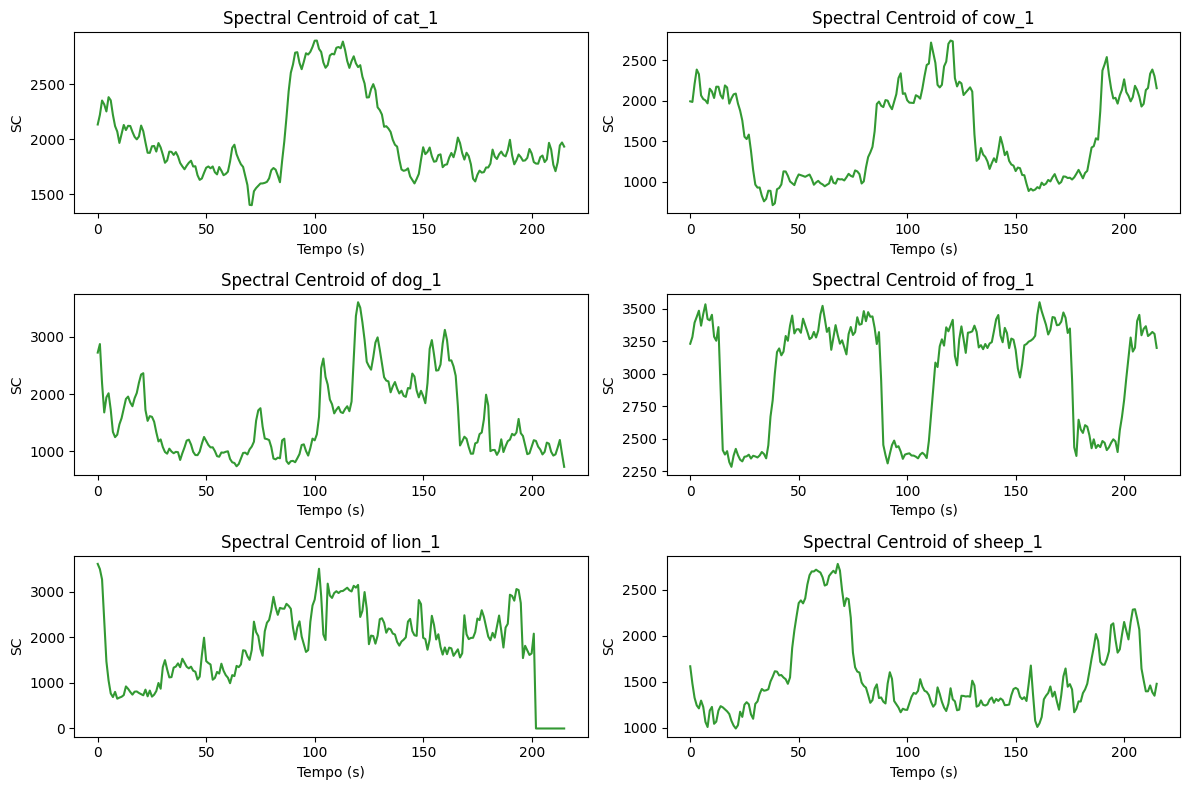

In [115]:
# Criar uma figura para o subplot
plt.figure(figsize=(12, 8))

# Contador de subplots
subplot_counter = 1

# Iterar sobre cada animal no dicionário
for idx, (animal, qtd) in enumerate(animals.items(), start=1):
    # Se for o primeiro animal do tipo
    if idx == 1 or animal != prev_animal:
        # Encontrar o índice do primeiro exemplo de cada animal
        audio_idx = labels.index(animal)

        # Obter o áudio e a taxa de amostragem
        audio = features[audio_idx]
        sr = lb.get_samplerate(f"NewDataset/new_{animal}_1.wav")

        # Coeficientes MFCC
        scs = np.array(audio_sc[audio_idx][0])

        # Adicionar um subplot para Spectral Centroid
        plt.subplot(3, 2, subplot_counter)
        plt.plot(scs.T, color='green', alpha=0.8)
        plt.title(f'Spectral Centroid of {animal}_1')
        plt.xlabel('Tempo (s)')
        plt.ylabel('SC')

        subplot_counter += 1

    prev_animal = animal

# Ajustar layout
plt.tight_layout()
plt.show()

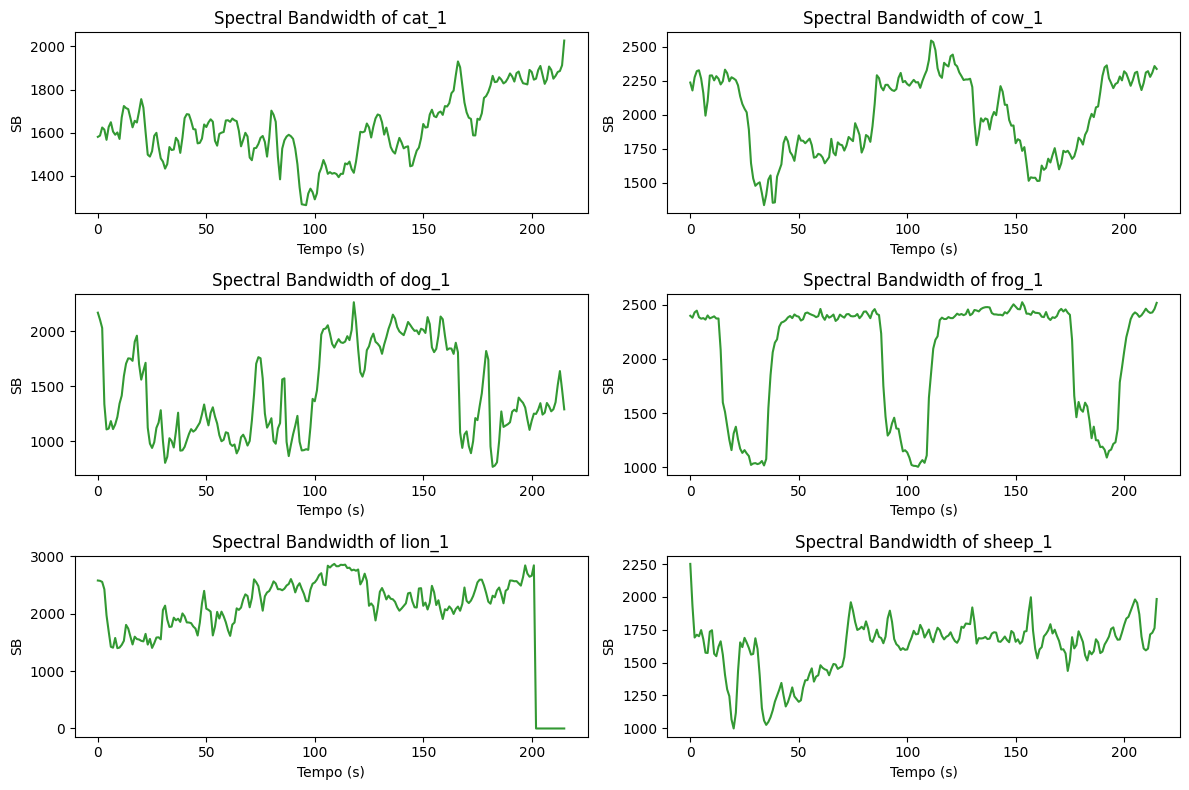

In [116]:
# Criar uma figura para o subplot
plt.figure(figsize=(12, 8))

# Contador de subplots
subplot_counter = 1

# Iterar sobre cada animal no dicionário
for idx, (animal, qtd) in enumerate(animals.items(), start=1):
    # Se for o primeiro animal do tipo
    if idx == 1 or animal != prev_animal:
        # Encontrar o índice do primeiro exemplo de cada animal
        audio_idx = labels.index(animal)

        # Obter o áudio e a taxa de amostragem
        audio = features[audio_idx]
        sr = lb.get_samplerate(f"NewDataset/new_{animal}_1.wav")

        # Coeficientes MFCC
        sbs = np.array(audio_sb[audio_idx][0])

        # Adicionar um subplot para Spectral Bandwidth
        plt.subplot(3, 2, subplot_counter)
        plt.plot(sbs.T, color='green', alpha=0.8)
        plt.title(f'Spectral Bandwidth of {animal}_1')
        plt.xlabel('Tempo (s)')
        plt.ylabel('SB')

        subplot_counter += 1

    prev_animal = animal

# Ajustar layout
plt.tight_layout()
plt.show()

In [117]:
# Feature normalization
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

# Turning features and labels into numpy arrays
features = np.array(features_normalized)
labels = np.array(labels)

print(features[0])

[0.25841273 0.20643383 0.20645986 ... 0.65061214 0.64289035 0.01329569]


In [118]:
features_dict = {}

feature_names = ['FFT',
                 'FFT Mean',
                 'FFT Var',
                 'MFCC',
                 'MFCC Mean',
                 'MFCC Var',
                 'S Centroid',
                 'S Centroid Mean',
                 'S Centroid Var',
                 'S Bandwidth',
                 'S Bandwidth Mean',
                 'S Bandwidth Var']

for i, feature_name in enumerate(feature_names):
    features_dict[feature_name] = features[:, i]

tabela = pd.DataFrame(features_dict, index=labels)
tabela.head()

,FFT,FFT Mean,FFT Var,MFCC,MFCC Mean,MFCC Var,S Centroid,S Centroid Mean,S Centroid Var,S Bandwidth,S Bandwidth Mean,S Bandwidth Var
cat,0.258413,0.206434,0.206460,0.206439,0.206258,0.206294,0.206248,0.206044,0.206024,0.205846,0.205882,0.205659
cat,0.084590,0.160817,0.160758,0.160932,0.160812,0.160733,0.160684,0.160574,0.160561,0.160378,0.160211,0.160305
cat,0.091887,0.028097,0.028042,0.028028,0.028151,0.028311,0.028180,0.028329,0.028076,0.027916,0.028099,0.028006
cat,0.055080,0.011252,0.011049,0.011132,0.011104,0.011123,0.011159,0.011126,0.011078,0.010980,0.011016,0.011078
cat,0.103422,0.040535,0.040376,0.040498,0.040472,0.040494,0.040489,0.040514,0.040456,0.040475,0.040434,0.040514


In [119]:
# Splitting data into training (80% = 635) and testing (20% = 159) set
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Training SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, Y_train)

# Prediction of the test set
Y_pred = svm_classifier.predict(X_test)

# Accuracy of the test
accuracy = accuracy_score(Y_test, Y_pred)

print("Accuracy: ", round((accuracy * 100), 2), "%")

Accuracy:  82.39 %


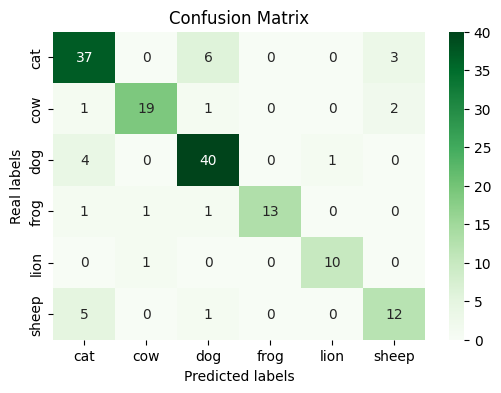

In [120]:
# Somar as matrizes de confusão de cada teste
conf_matrix = confusion_matrix(Y_test, Y_pred, labels=list(animals.keys()))

# Exibir Confusion Matrix
plt.figure(figsize=(6, 4))
ax = plt.subplot()
sns.heatmap(conf_matrix, cmap="Greens", annot=True, ax=ax)

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Real labels')
ax.xaxis.set_ticklabels(list(animals.keys()))
ax.yaxis.set_ticklabels(list(animals.keys()))

plt.show()

In [121]:
# Dangerous zone (delete directory)
# import shutil
# shutil.rmtree('ES413_Sinais', ignore_errors=True)
# shutil.rmtree('NewDataset', ignore_errors=True)